In [ ]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

!mkdir -p images
!wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/cars.jpg

# tạo thư mục checkpoints
!mkdir -p ../checkpoints/

# Tải từng checkpoint
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_base_plus.pt
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt


PyTorch version: 2.9.0+cu126
Torchvision version: 0.24.0+cu126
CUDA is available: True
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-x535e4lx
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-x535e4lx
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
--2025-11-28 10:08:27--  https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/cars.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1058188 (1.0M) [image/jpeg]
Saving to: ‘images/cars.jpg.1’

cars.

In [ ]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image


In [ ]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [ ]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1)

    ax.imshow(img)

# Test on one image

In [ ]:
image = Image.open('images/cars.jpg')
image = np.array(image.convert("RGB"))

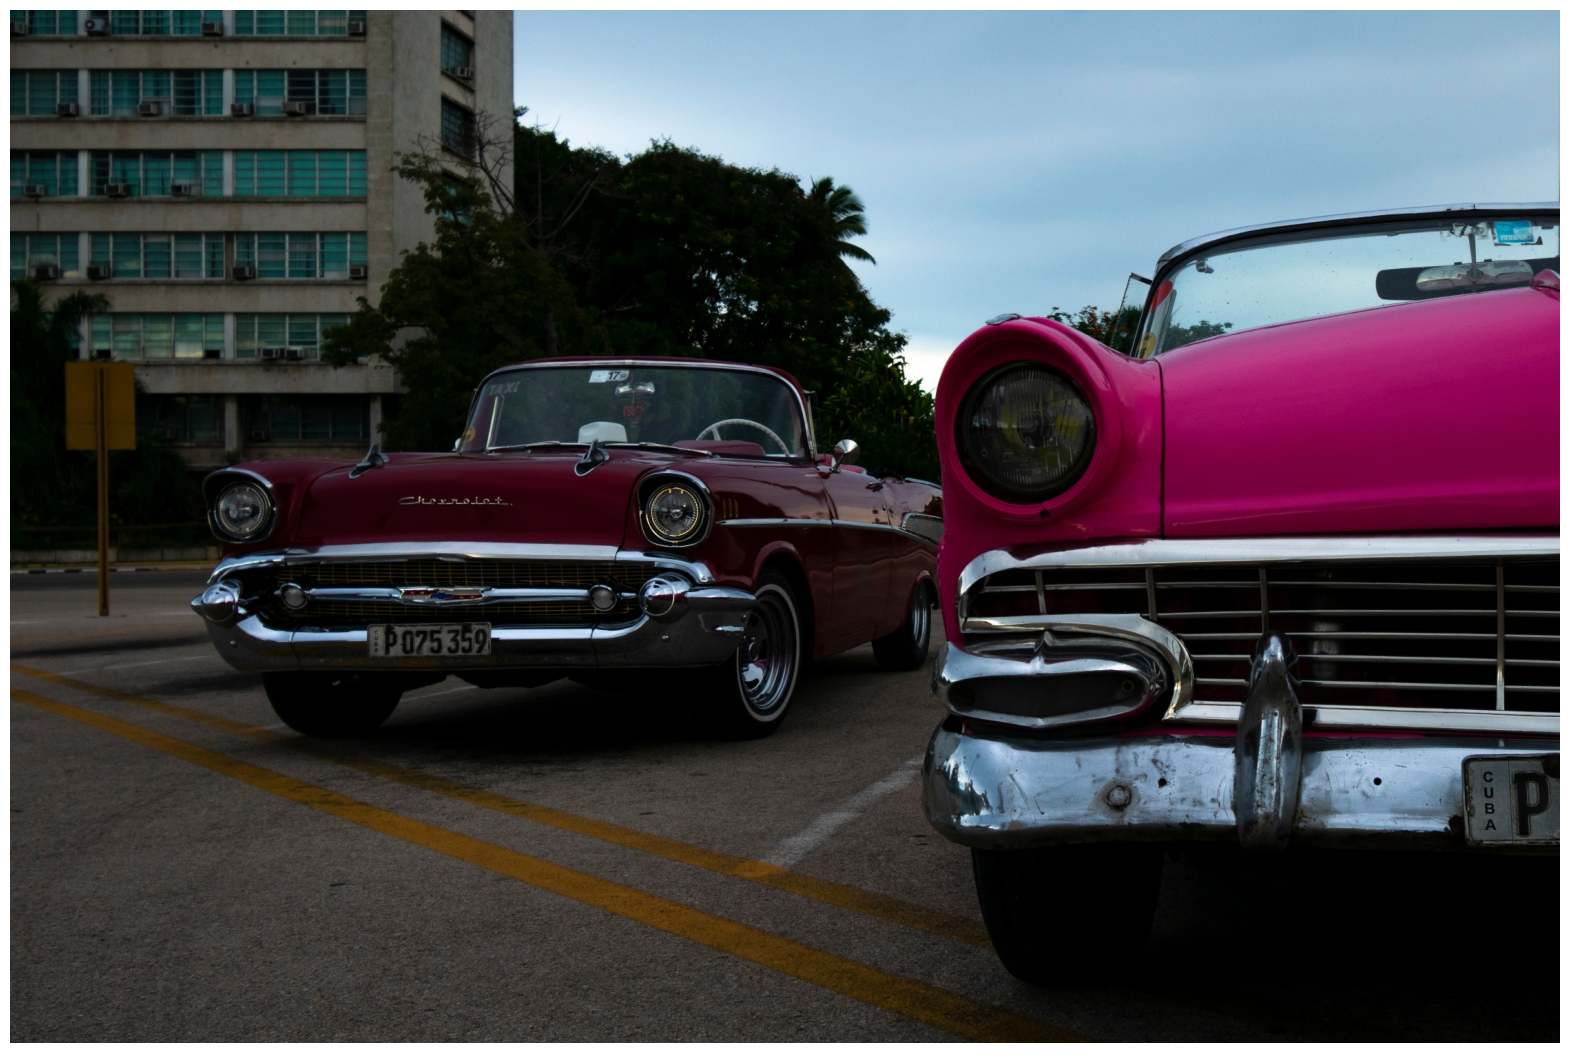

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.show()

# Init Sam Model

In [ ]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

import torch
torch.cuda.empty_cache()

sam2_checkpoint = "../checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

In [ ]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [ ]:
print(len(masks))
print(masks[0].keys())

29
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


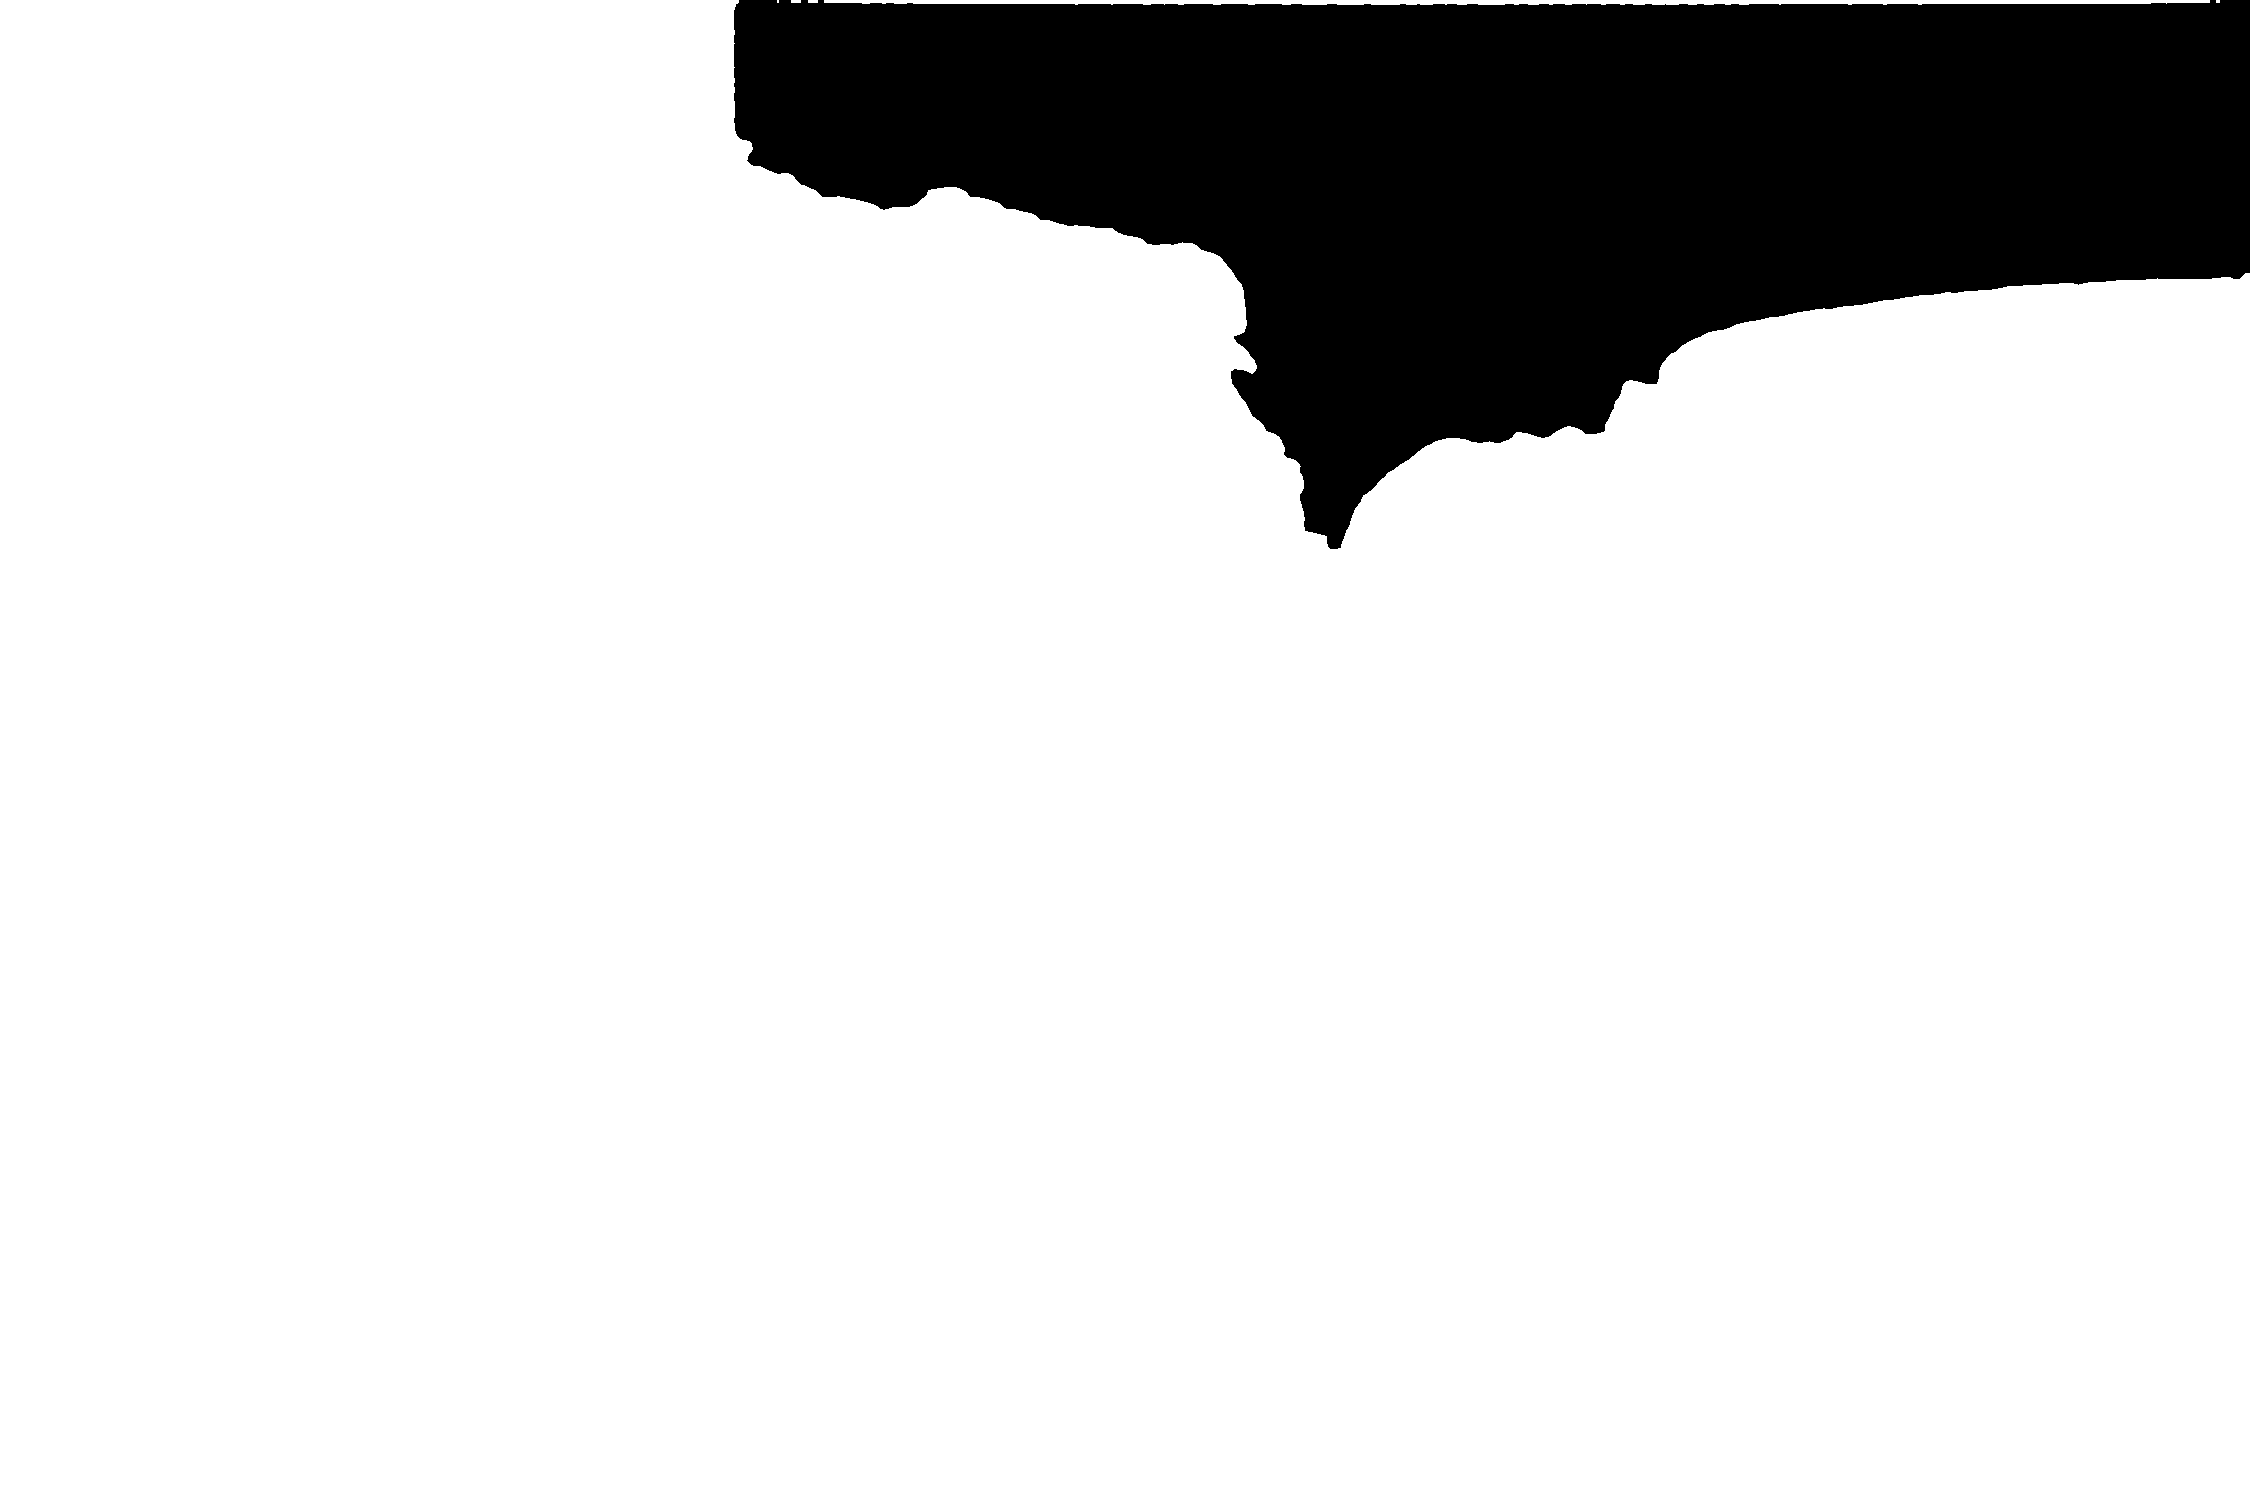

In [ ]:
import numpy as np
from PIL import Image

# mask boolean
mask_bool = masks[0]['segmentation']

# Chuyển sang 0,255
mask_img = ((mask_bool.astype(np.uint8) ^ 1) * 255)

# Tạo ảnh PIL
mask_pil = Image.fromarray(mask_img)

# Hiển thị
mask_pil

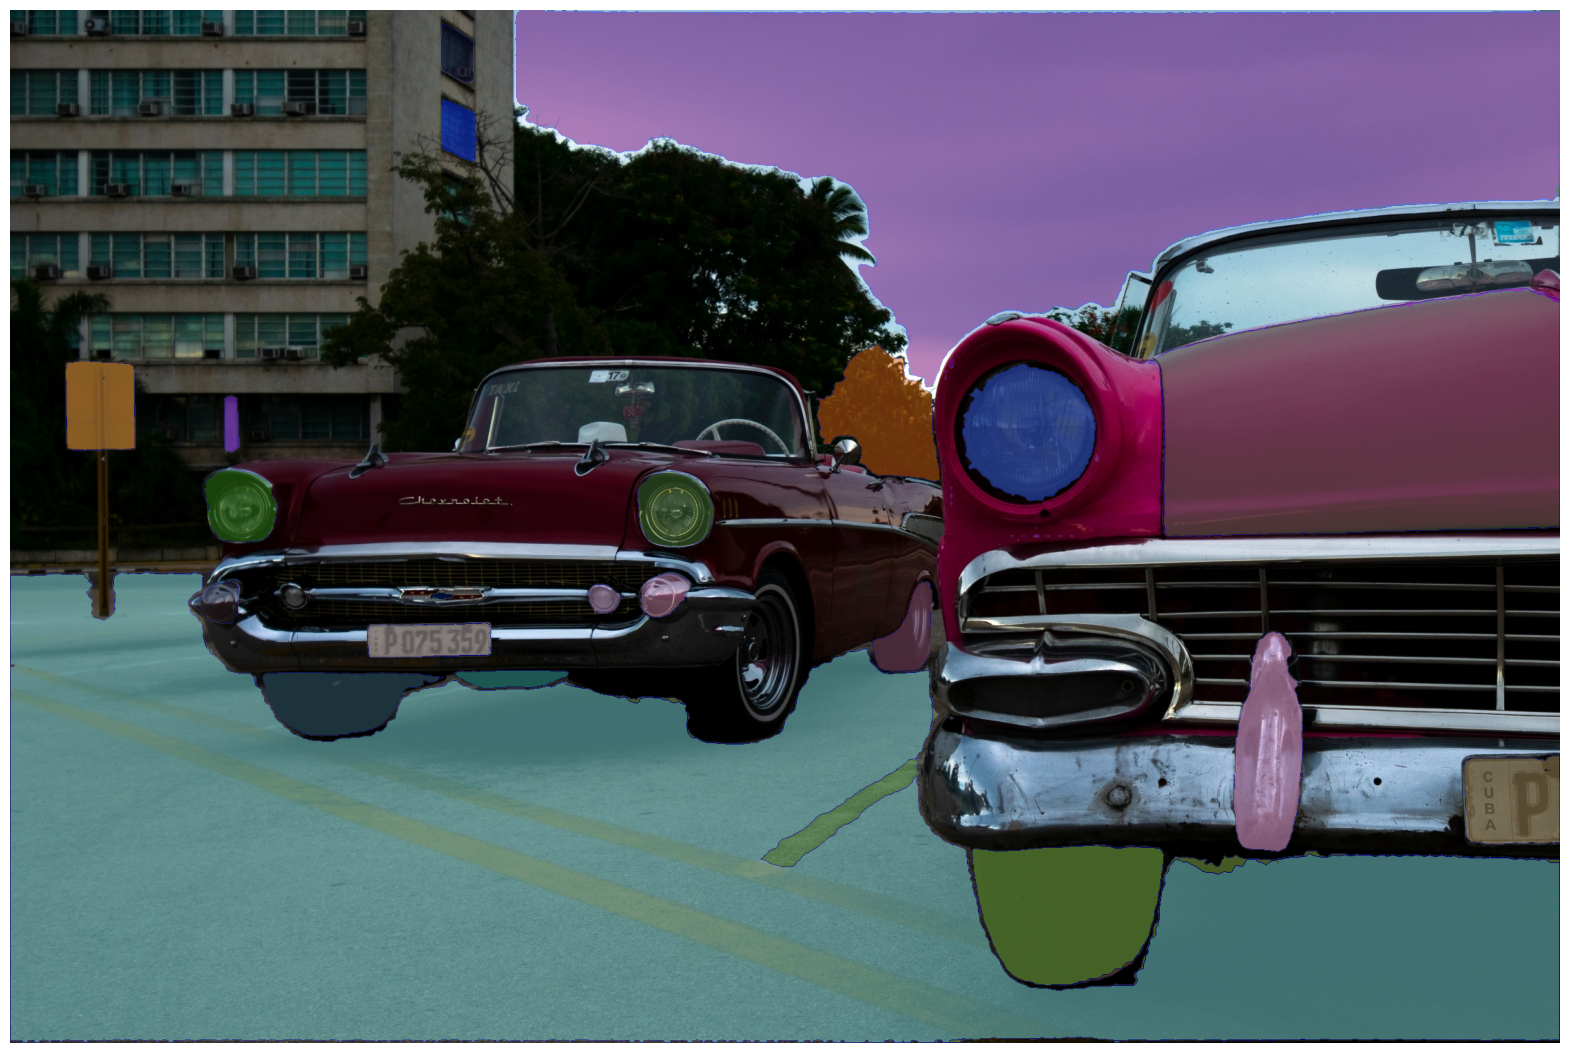

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

# Test on DIS5K dataset



In [ ]:
# 7. Tải Data (từ link bạn đã dùng)
!gdown --id 1O1eIuXX1hlGsV7qx4eSkjH231q7G1by1 -O DIS5K.zip
!unzip -q DIS5K.zip -d data/

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1O1eIuXX1hlGsV7qx4eSkjH231q7G1by1
From (redirected): https://drive.google.com/uc?id=1O1eIuXX1hlGsV7qx4eSkjH231q7G1by1&confirm=t&uuid=c4d7e521-c445-4510-a807-4644d4e8e980
To: /content/DIS5K.zip
 71% 4.01G/5.68G [01:00<00:12, 133MB/s]Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/urllib3/response.py", line 779, in _error_catcher
    yield
  File "/usr/local/lib/python3.12/dist-packages/urllib3/response.py", line 904, in _raw_read
    data = self._fp_read(amt, read1=read1) if not fp_closed else b""
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/urllib3/response.py", line 887, in _fp_read
    return self._fp.read(amt) if amt is not 

## Test on one image in DIS5K

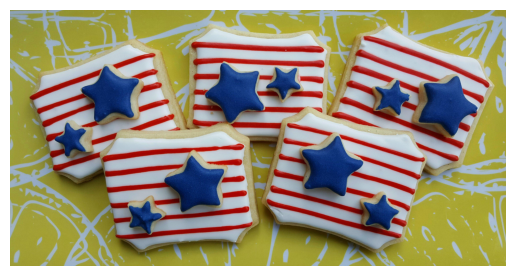

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Đường dẫn ảnh
img_path = "/content/data/DIS5K/DIS-TE1/im/1#Accessories#1#Bag#26345192014_f722d1ef0b_o.jpg"

# Load ảnh bằng OpenCV
image = cv2.imread(img_path)

# Kiểm tra xem ảnh đã load thành công chưa
if image is None:
    print("Không tìm thấy file ảnh, kiểm tra đường dẫn!")
else:
    # OpenCV load ảnh theo BGR, chuyển sang RGB để hiển thị đúng màu
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Hiển thị bằng matplotlib
    plt.imshow(image)
    plt.axis('off')
    plt.show()



In [ ]:
image = Image.open(img_path)
image = np.array(image.convert("RGB"))

In [ ]:
masks = mask_generator.generate(image)

In [ ]:
import torch
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# 1. Dọn dẹp VRAM tối đa
torch.cuda.empty_cache()

# 2. Cấu hình Tiny
sam2_checkpoint = "../checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

device = "cuda" if torch.cuda.is_available() else "cpu"

# 3. Load Model với bfloat16 (QUAN TRỌNG: Giúp tiết kiệm VRAM)
# Nếu GPU cũ (GTX 1080/Titan) không hỗ trợ bfloat16, hãy đổi thành torch.float16
dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16

print(f"Loading SAM2 Tiny on {device} with {dtype}...")
sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

# Ép model chạy ở chế độ tiết kiệm bộ nhớ này
sam2.to(dtype=dtype)

mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2,

    # 1. TẮT CROP (Quan trọng nhất để không OOM)
    # Default là 0. Bạn giữ là 0.
    # Mặc dù crop giúp ảnh nét hơn, nhưng với GPU 16GB chạy ảnh DIS5K thì crop là "tự sát".
    crop_n_layers=0,

    # 2. TĂNG MẬT ĐỘ ĐIỂM (Mạnh hơn Default)
    # Default là 32. Ta tăng lên 64.
    # Vì ta đã tắt crop (model nhìn toàn cảnh), ta cần chấm nhiều điểm hơn
    # để model không bỏ sót các chi tiết nhỏ như sợi dây, chân ghế.
    points_per_side=64,

    # 3. GIẢM BATCH (Để an toàn cho VRAM)
    # Vì ta đã tăng points_per_side lên 64 (tức là 64x64 = 4096 điểm),
    # ta phải giảm lượng xử lý song song xuống 16 hoặc 32 để tránh tràn bộ nhớ.
    points_per_batch=32, # Nếu vẫn lỗi, giảm xuống 16

    # 4. KÍCH HOẠT REFINEMENT (Vũ khí bí mật)
    # Default của SAM2 đôi khi tắt cái này để chạy nhanh.
    # Ta bật lên để SAM2 chạy thêm bước tinh chỉnh mask, giúp biên mượt hơn mà không tốn nhiều RAM.
    use_m2m=True,
    multimask_output=True,

    # 5. LỌC CHẶT CHẼ HƠN (Sạch hơn Default)
    # Default là 0.8. Với DIS5K, nền rất phức tạp, ta cần tăng lên 0.88
    # để đảm bảo chỉ lấy mask "xịn", loại bỏ mask rác.
    pred_iou_thresh=0.88,
    stability_score_thresh=0.95,
    min_mask_region_area=100,
)

print("Mask Generator is ready optimized for Low VRAM!")

Loading SAM2 Tiny on cuda with torch.bfloat16...
Mask Generator is ready optimized for Low VRAM!


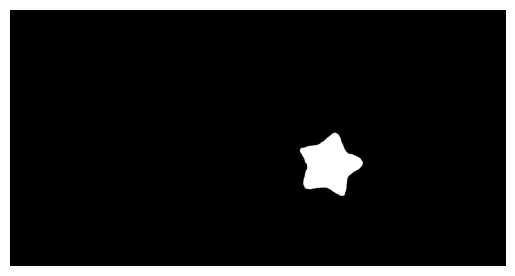

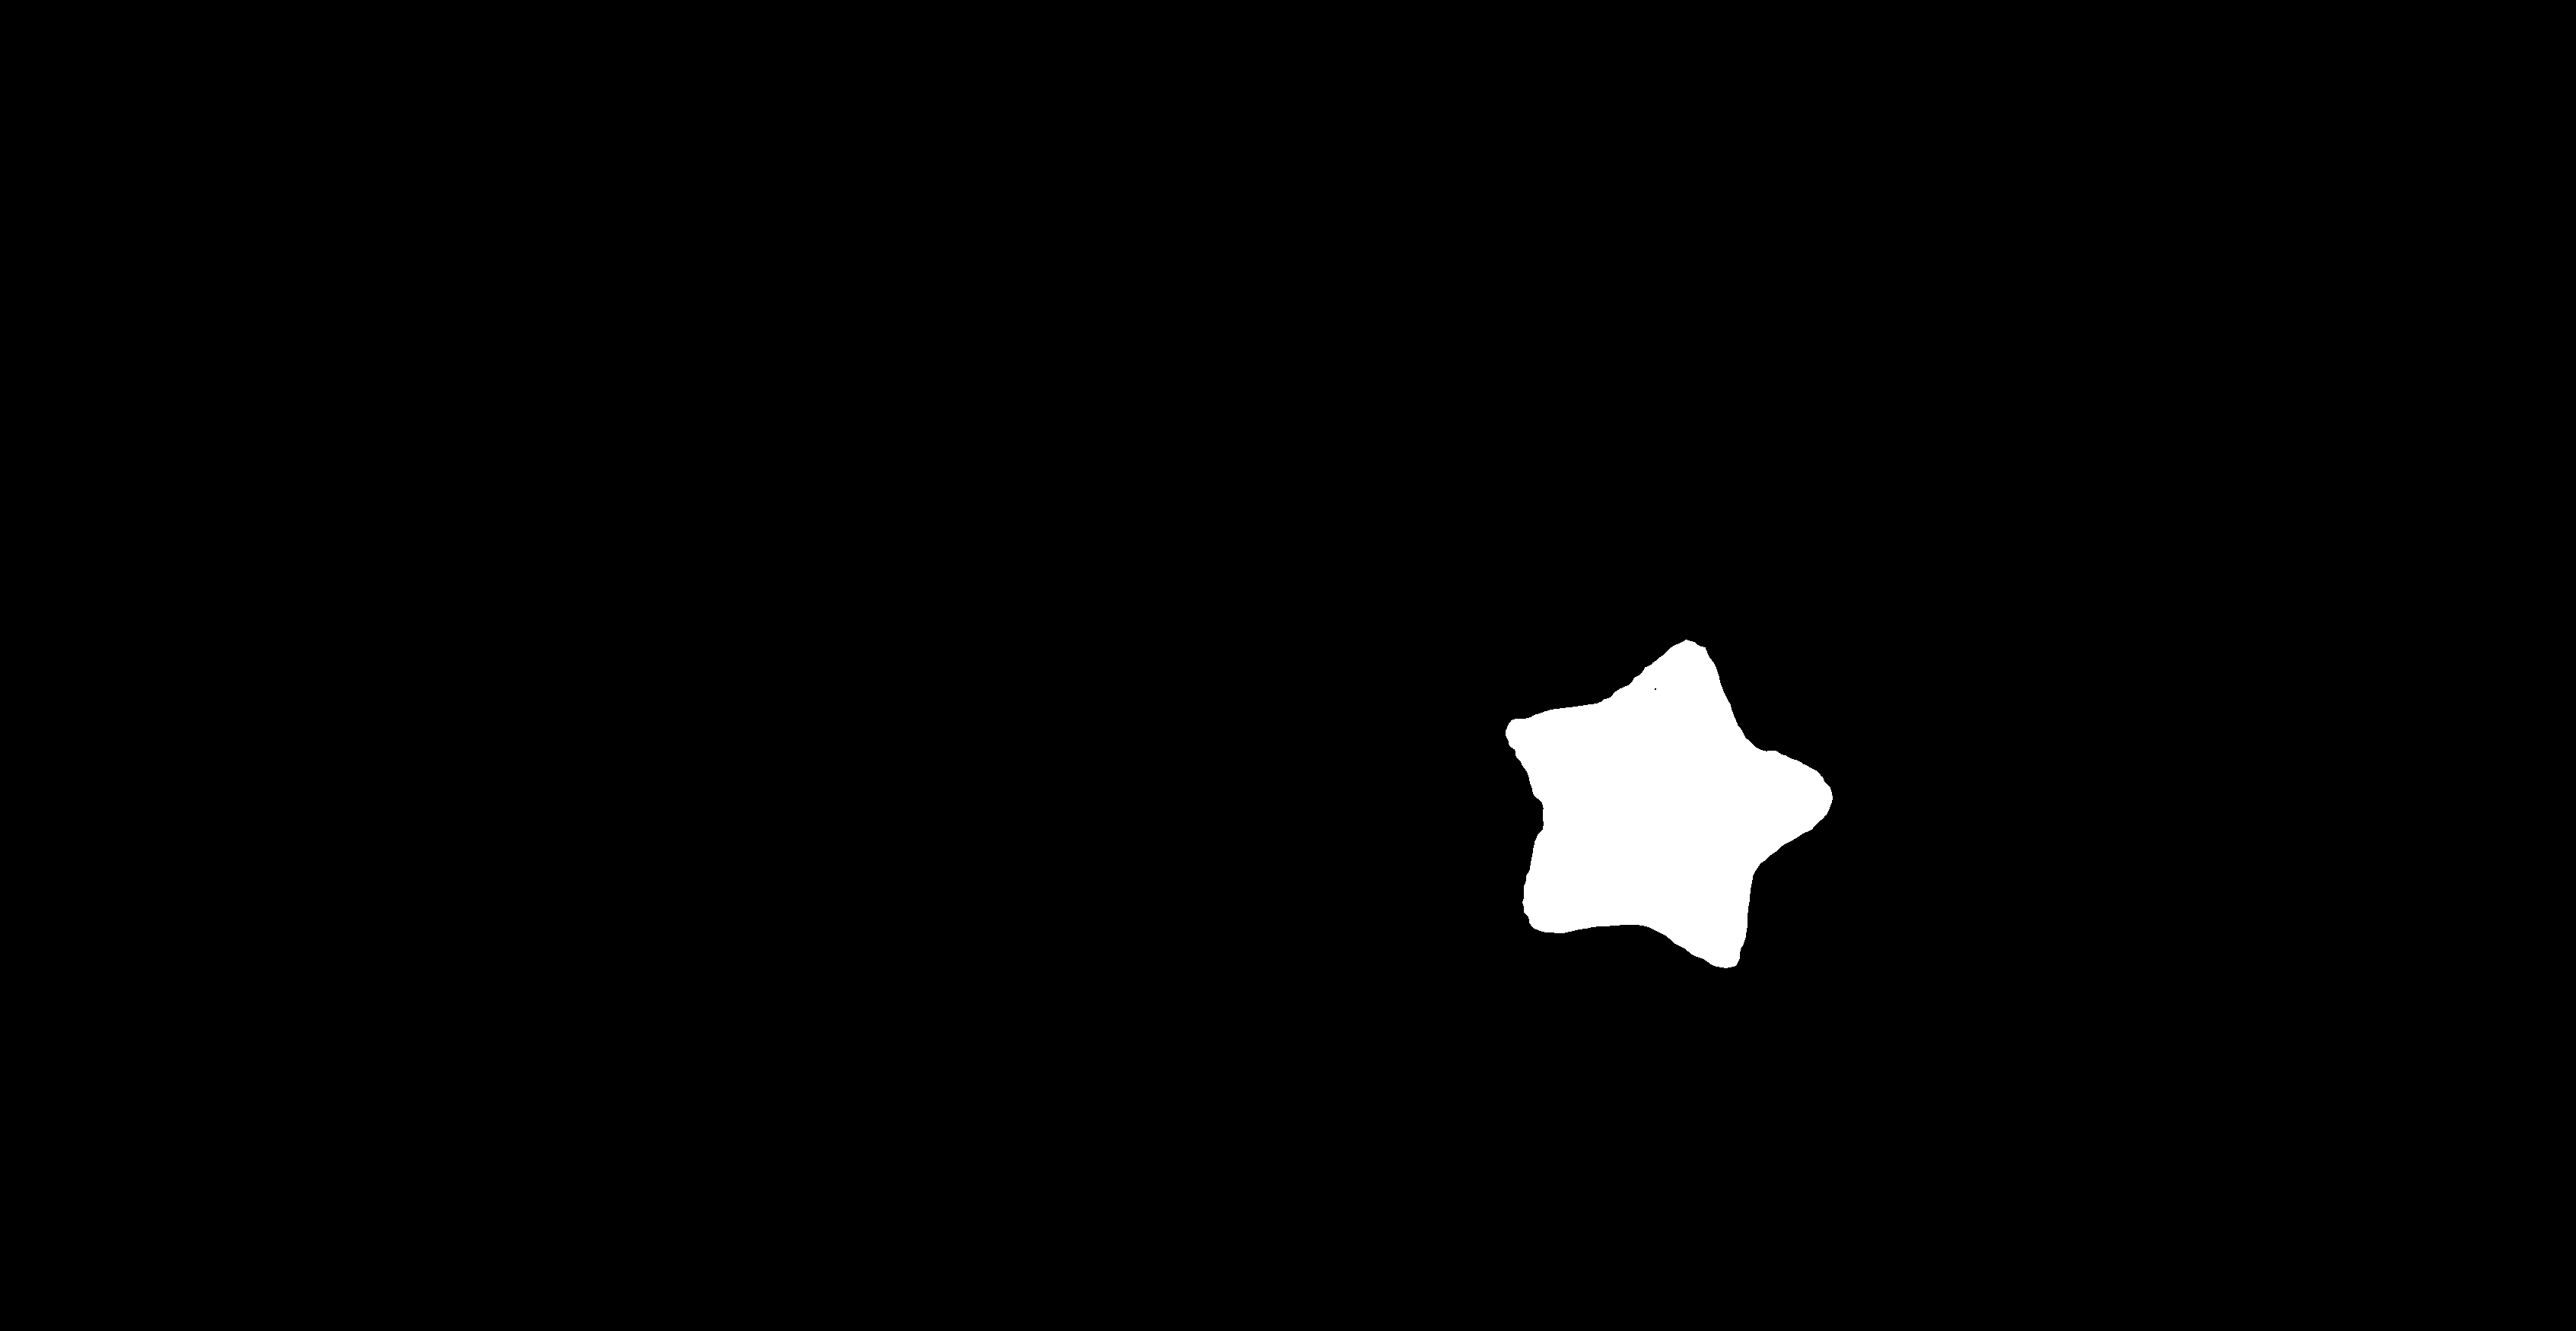

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def mask_to_pil(mask_bool, show=True):
    """
    Chuyển mask boolean sang PIL Image (0,255) và hiển thị nếu cần.

    Args:
        mask_bool (np.array): Mask boolean từ SAM2
        show (bool): True để hiển thị ảnh

    Returns:
        PIL.Image: Ảnh mask
    """
    # Chuyển mask boolean sang 0,255
    mask_img = (mask_bool.astype(np.uint8)) * 255

    # Tạo ảnh PIL
    mask_pil = Image.fromarray(mask_img)

    # Hiển thị nếu muốn
    if show:
        plt.imshow(mask_pil, cmap='gray')
        plt.axis('off')
        plt.show()

    return mask_pil
mask_to_pil(masks[0]['segmentation'])

In [ ]:
import os

input_folder = "/content/data/DIS5K/DIS-TE1/im"
output_folder = "/content/SAM2/DIS5K_masks/TE1"

os.makedirs(output_folder, exist_ok=True)


In [ ]:
# Dấu chấm than (!) để chạy lệnh hệ thống Linux
!rm -rf /content/SAM2/DIS5K_masks/TE1/*
print("Đã xóa sạch file trong folder dự đoán.")

Đã xóa sạch file trong folder dự đoán.


In [ ]:
import cv2
import os
import torch
import gc
import numpy as np
from PIL import Image

def save_masks_optimized(image_path, mask_generator, output_folder, top_k=5, max_dim=1536):
    """
    Chạy SAM2, tự động resize an toàn để tránh OOM, lọc Top-K mask lớn nhất
    và resize mask trả về kích thước gốc.
    """

    # 1. Kiểm tra path
    if not os.path.exists(image_path):
        print(f"Không tìm thấy file: {image_path}")
        return

    # 2. Load ảnh
    image = cv2.imread(image_path)
    if image is None:
        print(f"Không đọc được ảnh: {image_path}")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # ---------------------------------------------------------
    # BƯỚC AN TOÀN: RESIZE ẢNH NẾU QUÁ TO (CHỐNG CRASH)
    # ---------------------------------------------------------
    h, w = image.shape[:2]
    long_side = max(h, w)

    # Nếu ảnh > 1536px, thu nhỏ lại để vừa VRAM T4
    if long_side > max_dim:
        scale = max_dim / long_side
        new_w = int(w * scale)
        new_h = int(h * scale)
        image_input = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    else:
        image_input = image

    # 3. Generate masks (Có Try-Catch để không dừng chương trình)
    try:
        with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
            masks = mask_generator.generate(image_input)
    except torch.cuda.OutOfMemoryError:
        print(f"SKIPPING: Ảnh {os.path.basename(image_path)} quá nặng (OOM)!")
        torch.cuda.empty_cache()
        gc.collect()
        return
    except Exception as e:
        print(f"Lỗi lạ: {e}")
        return

    # 4. Lọc Top Mask
    if len(masks) == 0:
        print(f"Cảnh báo: Không tìm thấy mask nào cho {os.path.basename(image_path)}")
        return

    # Sắp xếp theo diện tích giảm dần -> Lấy Top K
    masks_sorted = sorted(masks, key=lambda x: x['area'], reverse=True)
    top_masks = masks_sorted[:top_k]

    # 5. Lưu kết quả
    os.makedirs(output_folder, exist_ok=True)
    base_name = os.path.splitext(os.path.basename(image_path))[0]

    saved_count = 0
    for i, mask in enumerate(top_masks):
        # Convert bool -> uint8
        mask_img = (mask['segmentation'].astype(np.uint8)) * 255

        # QUAN TRỌNG: Resize mask ngược lại về kích thước gốc (w, h)
        # Để đảm bảo khớp với Ground Truth khi tính điểm
        if long_side > max_dim:
            # Dùng Nearest để giữ biên sắc nét (không bị mờ thành màu xám)
            mask_img = cv2.resize(mask_img, (w, h), interpolation=cv2.INTER_NEAREST)

        save_path = os.path.join(output_folder, f"{base_name}_{i}.png")
        Image.fromarray(mask_img).save(save_path)
        saved_count += 1

    # print(f"Đã lưu {saved_count} mask cho {base_name}")

    # 6. Dọn dẹp GPU triệt để
    del masks
    del top_masks
    del image
    del image_input
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect() # Gom rác bộ nhớ Python

In [ ]:
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
if torch.cuda.is_available():
    torch.cuda.empty_cache()
# Lấy danh sách ảnh
image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

print(f"Bắt đầu xử lý {len(image_files)} ảnh...")

for idx, img_name in enumerate(image_files):
    img_path = os.path.join(input_folder, img_name)

    # Gọi hàm lưu thông minh mới
    save_masks_optimized(img_path, mask_generator, output_folder, top_k=10)

    if (idx + 1) % 50 == 0:
        print(f"--> Đã xử lý: {idx + 1} ảnh")

print("Hoàn tất generation!")


Bắt đầu xử lý 500 ảnh...
Cảnh báo: Không tìm thấy mask nào cho 21#Tool#6#Key#4288658681_58679b37e2_o.jpg


In [ ]:
import os
import numpy as np
from PIL import Image
from skimage import measure
from scipy.spatial.distance import directed_hausdorff
from scipy.spatial import cKDTree
import pandas as pd

# ---------------------------
# Hàm metrics
# ---------------------------
def compute_segmentation_metrics(gt_mask, pred_masks, boundary_radius=1):
    def iou_score(pred, gt):
        intersection = np.logical_and(pred, gt).sum()
        union = np.logical_or(pred, gt).sum()
        return intersection / union if union > 0 else 1.0

    def dice_score(pred, gt):
        intersection = np.logical_and(pred, gt).sum()
        return 2 * intersection / (pred.sum() + gt.sum()) if (pred.sum() + gt.sum()) > 0 else 1.0

    # Chọn predicted mask tốt nhất
    best_iou = 0
    best_dice = 0
    best_pred = None
    if not pred_masks:
        return {
            "best_iou": 0.0,
            "best_dice": 0.0,
            "boundary_f1": 0.0,
            "hausdorff_distance": np.nan
        }

    for pred in pred_masks:
        iou = iou_score(pred, gt_mask)
        if iou > best_iou:
            best_iou = iou
            best_pred = pred

    if best_pred is not None:
        best_dice = dice_score(best_pred, gt_mask)
    else:
        # Should not happen if pred_masks is not empty, but as a safeguard
        best_dice = 0.0

    # Boundary metrics
    gt_contours = measure.find_contours(gt_mask.astype(np.uint8), 0.5)

    if best_pred is None:
        boundary_f1 = 0.0
        hausdorff_dist = np.nan
    else:
        pred_contours = measure.find_contours(best_pred.astype(np.uint8), 0.5)

        def contour_points(contours):
            return np.vstack([c for c in contours]) if len(contours) > 0 else np.zeros((0,2))

        gt_points = contour_points(gt_contours)
        pred_points = contour_points(pred_contours)

        if len(gt_points)==0 or len(pred_points)==0:
            boundary_f1 = 0.0
            hausdorff_dist = np.nan
        else:
            gt_tree = cKDTree(gt_points)
            pred_tree = cKDTree(pred_points)

            p_matches = gt_tree.query_ball_point(pred_points, r=boundary_radius)
            precision = np.count_nonzero([len(m)>0 for m in p_matches]) / len(pred_points)

            r_matches = pred_tree.query_ball_point(gt_points, r=boundary_radius)
            recall = np.count_nonzero([len(m)>0 for m in r_matches]) / len(gt_points)

            boundary_f1 = 2 * precision * recall / (precision + recall) if (precision+recall)>0 else 0.0

            # Hausdorff
            hd1 = directed_hausdorff(gt_points, pred_points)[0]
            hd2 = directed_hausdorff(pred_points, gt_points)[0]
            hausdorff_dist = max(hd1, hd2)

    return {
        "best_iou": best_iou,
        "best_dice": best_dice,
        "boundary_f1": boundary_f1,
        "hausdorff_distance": hausdorff_dist
    }

# ---------------------------
# Batch process
# ---------------------------
gt_folder = "/content/data/DIS5K/DIS-TE1/gt"
pred_folder = "/content/SAM2/DIS5K_masks/TE1"

all_gt_files = [f for f in os.listdir(gt_folder) if f.lower().endswith(('.png','.jpg'))]
results = []

for gt_file in all_gt_files:
    base_name = os.path.splitext(gt_file)[0]
    gt_mask_original = np.array(Image.open(os.path.join(gt_folder, gt_file))) > 0

    # Load tất cả predicted masks tương ứng
    pred_files = [f for f in os.listdir(pred_folder) if f.startswith(base_name)]
    pred_masks_loaded = [np.array(Image.open(os.path.join(pred_folder, f))) > 0 for f in pred_files]

    if not pred_masks_loaded:
        # Handle case where no masks were generated for this image
        metrics = {
            "best_iou": 0.0,
            "best_dice": 0.0,
            "boundary_f1": 0.0,
            "hausdorff_distance": np.nan
        }
    else:
        # Resize gt_mask to match the shape of predicted masks
        # Assuming all predicted masks for a single image have the same shape
        target_height, target_width = pred_masks_loaded[0].shape

        # Convert boolean gt_mask to uint8 before PIL conversion for correct resizing
        gt_mask_resized_pil = Image.fromarray(gt_mask_original.astype(np.uint8) * 255)
        gt_mask_resized_pil = gt_mask_resized_pil.resize((target_width, target_height), Image.NEAREST) # PIL resize takes (width, height)
        gt_mask = np.array(gt_mask_resized_pil) > 0 # Convert back to boolean

        metrics = compute_segmentation_metrics(gt_mask, pred_masks_loaded)

    metrics['image'] = gt_file
    results.append(metrics)

# ---------------------------
# Lưu CSV
# ---------------------------
df = pd.DataFrame(results)
df.to_csv("/content/DIS5K_TE1_metrics.csv", index=False)
print("Đã lưu CSV metrics.")

# ---------------------------
# Tính mean / std toàn dataset
# ---------------------------
mean_metrics = df.mean(numeric_only=True)
std_metrics = df.std(numeric_only=True)

print("Mean metrics:\n", mean_metrics)
print("Std metrics:\n", std_metrics)


In [ ]:
import shutil
from google.colab import files

# Ví dụ CSV bạn vừa tạo
file_path = "/content/DIS5K_TE1_metrics.csv"
files.download(file_path)

# Nén folder mask output
shutil.make_archive("/content/SAM2", 'zip', "/content/SAM2/DIS5K_masks/TE1")

# Download zip
files.download("/content/SAM2.zip")


In [ ]:
import os
import numpy as np
from PIL import Image
from skimage import measure
from scipy.spatial.distance import directed_hausdorff
from scipy.spatial import cKDTree
import pandas as pd
import cv2

# ---------------------------
# Hàm metrics NÂNG CAO
# ---------------------------
def compute_segmentation_metrics(gt_mask, pred_masks, boundary_radius=2):

    # --- Helper: Basic Region Metrics ---
    def iou_score(pred, gt):
        intersection = np.logical_and(pred, gt).sum()
        union = np.logical_or(pred, gt).sum()
        return intersection / union if union > 0 else 1.0

    def dice_score(pred, gt):
        intersection = np.logical_and(pred, gt).sum()
        return 2 * intersection / (pred.sum() + gt.sum()) if (pred.sum() + gt.sum()) > 0 else 1.0

    # 1. Chọn mask tốt nhất (Oracle selection based on IoU)
    best_iou = 0
    best_pred = None

    if not pred_masks:
        return {
            "best_iou": 0.0, "best_dice": 0.0,
            "boundary_f1": 0.0, "hausdorff_dist": np.nan,
            "assd": np.nan, "hd95": np.nan
        }

    for pred in pred_masks:
        iou = iou_score(pred, gt_mask)
        if iou > best_iou:
            best_iou = iou
            best_pred = pred

    best_dice = dice_score(best_pred, gt_mask) if best_pred is not None else 0.0

    # 2. Boundary Metrics Calculation
    if best_pred is None:
        return {
            "best_iou": 0.0, "best_dice": 0.0,
            "boundary_f1": 0.0, "hausdorff_dist": np.nan,
            "assd": np.nan, "hd95": np.nan
        }

    # Extract contours
    gt_contours = measure.find_contours(gt_mask.astype(np.uint8), 0.5)
    pred_contours = measure.find_contours(best_pred.astype(np.uint8), 0.5)

    def contour_points(contours):
        return np.vstack([c for c in contours]) if len(contours) > 0 else np.zeros((0,2))

    gt_points = contour_points(gt_contours)
    pred_points = contour_points(pred_contours)

    # Nếu không có biên (ảnh đen hoặc trắng hoàn toàn)
    if len(gt_points) == 0 or len(pred_points) == 0:
        return {
            "best_iou": best_iou, "best_dice": best_dice,
            "boundary_f1": 0.0,
            "hausdorff_dist": np.nan, "assd": np.nan, "hd95": np.nan
        }

    # --- Xây dựng KDTree (Dùng chung cho tất cả metrics biên) ---
    gt_tree = cKDTree(gt_points)
    pred_tree = cKDTree(pred_points)

    # --- A. Boundary F1 Score ---
    # query_ball_point đếm số điểm nằm trong bán kính r
    p_matches = gt_tree.query_ball_point(pred_points, r=boundary_radius)
    precision = np.count_nonzero([len(m)>0 for m in p_matches]) / len(pred_points)

    r_matches = pred_tree.query_ball_point(gt_points, r=boundary_radius)
    recall = np.count_nonzero([len(m)>0 for m in r_matches]) / len(gt_points)

    boundary_f1 = 2 * precision * recall / (precision + recall) if (precision+recall)>0 else 0.0

    # --- B. Distance-based Metrics (Hausdorff, ASSD, HD95) ---
    # query trả về (khoảng cách, index) đến điểm gần nhất
    # k=1 nghĩa là tìm 1 điểm gần nhất
    dist_pred_to_gt, _ = gt_tree.query(pred_points, k=1)
    dist_gt_to_pred, _ = pred_tree.query(gt_points, k=1)

    # 1. Hausdorff Distance (Standard - Max of nearest distances)
    # Tự tính thay vì dùng scipy.directed_hausdorff để tận dụng tree đã build
    hd_forward = np.max(dist_pred_to_gt)
    hd_backward = np.max(dist_gt_to_pred)
    hausdorff_dist = max(hd_forward, hd_backward)

    # 2. HD95 (95% Hausdorff - Robust to outliers)
    # Gộp tất cả khoảng cách lại và lấy phân vị 95
    all_dists = np.concatenate([dist_pred_to_gt, dist_gt_to_pred])
    hd95 = np.percentile(all_dists, 95)

    # 3. ASSD (Average Symmetric Surface Distance)
    # Trung bình cộng khoảng cách 2 chiều
    assd = (dist_pred_to_gt.sum() + dist_gt_to_pred.sum()) / (len(pred_points) + len(gt_points))

    return {
        "best_iou": best_iou,
        "best_dice": best_dice,
        "boundary_f1": boundary_f1,
        "hausdorff_dist": hausdorff_dist,
        "hd95": hd95,
        "assd": assd
    }

# ---------------------------
# Batch process (Giữ nguyên logic chuẩn đã sửa ở trên)
# ---------------------------
gt_folder = "/content/data/DIS5K/DIS-TE1/gt"
pred_folder = "/content/SAM2/DIS5K_masks/TE1"

all_gt_files = [f for f in os.listdir(gt_folder) if f.lower().endswith(('.png','.jpg','.jpeg'))]
results = []

print(f"Starting evaluation on {len(all_gt_files)} images...")

for i, gt_file in enumerate(all_gt_files):
    base_name = os.path.splitext(gt_file)[0]

    # Load GT
    gt_path = os.path.join(gt_folder, gt_file)
    gt_mask_original = np.array(Image.open(gt_path).convert('L')) > 0
    h_gt, w_gt = gt_mask_original.shape

    # Find predictions
    pred_files = [f for f in os.listdir(pred_folder)
                  if f.startswith(base_name) and
                  (f[len(base_name):].startswith('.') or f[len(base_name):].startswith('_'))]

    if not pred_files:
        continue

    pred_masks_processed = []
    for f in pred_files:
        p_path = os.path.join(pred_folder, f)
        p_mask = np.array(Image.open(p_path).convert('L'))

        # Resize Pred to GT size (Fix lỗi logic cũ)
        if p_mask.shape != (h_gt, w_gt):
            p_mask = cv2.resize(p_mask, (w_gt, h_gt), interpolation=cv2.INTER_NEAREST)

        pred_masks_processed.append(p_mask > 0)

    # Compute
    metrics = compute_segmentation_metrics(gt_mask_original, pred_masks_processed)
    metrics['image'] = gt_file
    results.append(metrics)

    if i % 50 == 0:
        print(f"Processed {i} images...")

# ---------------------------
# Save & Report
# ---------------------------
df = pd.DataFrame(results)
output_csv = "/content/DIS5K_TE1_advanced_metrics.csv"
df.to_csv(output_csv, index=False)

print("\n" + "="*40)
print("FINAL RESULTS (Mean):")
print("-" * 40)
# Format in cho đẹp
mean_vals = df.mean(numeric_only=True)
print(f"IoU:       {mean_vals['best_iou']:.4f}")
print(f"Dice:      {mean_vals['best_dice']:.4f}")
print(f"Bound F1:  {mean_vals['boundary_f1']:.4f}")
print("-" * 20)
print(f"ASSD:      {mean_vals['assd']:.4f} pixels (Càng thấp càng tốt)")
print(f"HD95:      {mean_vals['hd95']:.4f} pixels (Càng thấp càng tốt)")
print(f"Hausdorff: {mean_vals['hausdorff_dist']:.4f} pixels")
print("="*40)

In [ ]:
import shutil
from google.colab import files

# Ví dụ CSV bạn vừa tạo
file_path = "/content/DIS5K_TE1_metrics.csv"
files.download(file_path)

# Nén folder mask output
shutil.make_archive("/content/SAM2", 'zip', "/content/SAM2/DIS5K_masks/TE1")

# Download zip
files.download("/content/SAM2.zip")


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from skimage import measure
from py_sod_metrics import MAE, Emeasure, Fmeasure, Smeasure, WeightedFmeasure

# -------------------------------------------------------------------------
# PHẦN 1: HÀM TÍNH TOÁN METRICS HÌNH HỌC & BIÊN (IoU, Dice, HD95, BF1)
# -------------------------------------------------------------------------
def compute_geometric_metrics(gt_mask, pred_mask, boundary_radius=2):
    """
    Tính các chỉ số Geometric & Boundary cho 1 cặp ảnh (đã resize về cùng cỡ).
    """
    # 1. IoU & Dice
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    iou = intersection / union if union > 0 else 1.0
    dice = 2 * intersection / (pred_mask.sum() + gt_mask.sum()) if (pred_mask.sum() + gt_mask.sum()) > 0 else 1.0

    # 2. Boundary Metrics Setup
    # Tìm contours
    gt_contours = measure.find_contours(gt_mask.astype(np.uint8), 0.5)
    pred_contours = measure.find_contours(pred_mask.astype(np.uint8), 0.5)

    def get_points(contours):
        return np.vstack(contours) if len(contours) > 0 else np.zeros((0, 2))

    gt_points = get_points(gt_contours)
    pred_points = get_points(pred_contours)

    # Xử lý trường hợp không có biên (mask đen hoặc trắng xóa)
    if len(gt_points) == 0 or len(pred_points) == 0:
        return {
            "IoU": iou, "Dice": dice,
            "Boundary_F1": 0.0, "HD95": np.nan
        }

    # Dùng KDTree để tính khoảng cách nhanh
    gt_tree = cKDTree(gt_points)
    pred_tree = cKDTree(pred_points)

    # --- Boundary F1 Score ---
    # Precision: Số điểm pred nằm gần gt
    p_matches = gt_tree.query_ball_point(pred_points, r=boundary_radius)
    precision = np.count_nonzero([len(m) > 0 for m in p_matches]) / len(pred_points)

    # Recall: Số điểm gt nằm gần pred
    r_matches = pred_tree.query_ball_point(gt_points, r=boundary_radius)
    recall = np.count_nonzero([len(m) > 0 for m in r_matches]) / len(gt_points)

    bf1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    # --- 95% Hausdorff Distance (HD95) ---
    dist_pred_to_gt, _ = gt_tree.query(pred_points, k=1)
    dist_gt_to_pred, _ = pred_tree.query(gt_points, k=1)

    all_dists = np.concatenate([dist_pred_to_gt, dist_gt_to_pred])
    hd95 = np.percentile(all_dists, 95) # Lấy phân vị 95 để loại bỏ nhiễu

    return {
        "IoU": iou,
        "Dice": dice,
        "Boundary_F1": bf1,
        "HD95": hd95
    }

# -------------------------------------------------------------------------
# PHẦN 2: PIPELINE ĐÁNH GIÁ TỔNG HỢP (Kết hợp py_sod_metrics)
# -------------------------------------------------------------------------

# Cấu hình đường dẫn
gt_folder = "/content/data/DIS5K/DIS-TE1/gt"
pred_folder = "/content/SAM2/DIS5K_masks/TE1"

# Khởi tạo các bộ đo chuẩn SOD/DIS
sod_mae = MAE()
sod_fm = Fmeasure(beta=0.3)
sod_sm = Smeasure(alpha=0.5)
sod_em = Emeasure()
sod_wfm = WeightedFmeasure(beta=1)

# List để lưu kết quả từng ảnh
per_image_results = []

all_gt_files = [f for f in os.listdir(gt_folder) if f.lower().endswith(('.png','.jpg','.jpeg'))]
print(f"Bắt đầu đánh giá toàn diện trên {len(all_gt_files)} ảnh...")

for i, gt_file in enumerate(all_gt_files):
    base_name = os.path.splitext(gt_file)[0]

    # 1. Load GT (Giữ nguyên gốc)
    gt_path = os.path.join(gt_folder, gt_file)
    gt_img = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    if gt_img is None: continue
    h_gt, w_gt = gt_img.shape
    gt_bool = gt_img > 0 # Dạng boolean cho Geometric metrics

    # 2. Load & Select Best Prediction
    # Tìm tất cả mask candidates cho ảnh này (vì SAM2 có thể xuất nhiều mask)
    candidates = [f for f in os.listdir(pred_folder)
                  if f.startswith(base_name) and (f[len(base_name):].startswith('.') or f[len(base_name):].startswith('_'))]

    best_iou_temp = -1
    best_pred_mask = np.zeros_like(gt_img) # Mặc định mask đen nếu không tìm thấy

    if candidates:
        for f in candidates:
            p_img = cv2.imread(os.path.join(pred_folder, f), cv2.IMREAD_GRAYSCALE)
            # Resize Pred -> GT (BẮT BUỘC)
            if p_img.shape != (h_gt, w_gt):
                p_img = cv2.resize(p_img, (w_gt, h_gt), interpolation=cv2.INTER_NEAREST)

            # Tính nhanh IoU để chọn mask tốt nhất (Oracle selection)
            p_bool = p_img > 0
            intersection = np.logical_and(p_bool, gt_bool).sum()
            union = np.logical_or(p_bool, gt_bool).sum()
            iou = intersection / union if union > 0 else 1.0

            if iou > best_iou_temp:
                best_iou_temp = iou
                best_pred_mask = p_img # Lưu dạng 0-255

    # 3. Tính toán nhóm Geometric Metrics (IoU, Dice, HD95, BF1)
    # Convert sang boolean cho hàm tính toán
    geom_res = compute_geometric_metrics(gt_bool, best_pred_mask > 0)

    # 4. Tính toán nhóm SOD Metrics (MAE, S, F, E)
    # Convert sang mảng uint8 chuẩn
    pred_uint8 = best_pred_mask.astype(np.uint8)
    gt_uint8 = gt_img.astype(np.uint8)

    sod_mae.step(pred_uint8, gt_uint8)
    sod_fm.step(pred_uint8, gt_uint8)
    sod_sm.step(pred_uint8, gt_uint8)
    sod_em.step(pred_uint8, gt_uint8)
    sod_wfm.step(pred_uint8, gt_uint8)

    # 5. Lưu kết quả lẻ
    row_data = {
        "Image": gt_file,
        "IoU": geom_res["IoU"],
        "Dice": geom_res["Dice"],
        "Boundary_F1": geom_res["Boundary_F1"],
        "HD95": geom_res["HD95"]
    }
    per_image_results.append(row_data)

    if (i+1) % 50 == 0:
        print(f"Processed {i+1} images...")

# -------------------------------------------------------------------------
# PHẦN 3: TỔNG HỢP VÀ XUẤT BÁO CÁO
# -------------------------------------------------------------------------

# A. Lấy kết quả trung bình của nhóm Geometric
df_geom = pd.DataFrame(per_image_results)
mean_geom = df_geom.mean(numeric_only=True)

# B. Lấy kết quả của nhóm SOD Metrics
fm_res = sod_fm.get_results()['fm']
em_res = sod_em.get_results()['em']

final_metrics = {
    # --- Nhóm 1: Cơ bản (Regional) ---
    "IoU": mean_geom["IoU"],
    "Dice": mean_geom["Dice"],

    # --- Nhóm 2: Biên & Hình học (Geometric/Boundary) ---
    "Boundary_F1": mean_geom["Boundary_F1"],
    "HD95 (px)": mean_geom["HD95"],

    # --- Nhóm 3: Chuẩn DIS5K / SOD Papers ---
    "MAE (M) ↓": sod_mae.get_results()['mae'],
    "S_alpha ↑": sod_sm.get_results()['sm'],
    "F_beta_max ↑": fm_res['curve'].max(),
    "F_beta_w ↑": sod_wfm.get_results()['wfm'],
    "E_phi_mean ↑": em_res['curve'].mean()
}

# Lưu file CSV chi tiết từng ảnh
df_geom.to_csv("/content/DIS5K_TE1_Detailed_Report.csv", index=False)

# In bảng kết quả đẹp để copy vào báo cáo
print("\n" + "#"*50)
print("BẢNG KẾT QUẢ FINAL (Dùng cho bài báo)")
print("#"*50)
print(f"{'METRIC':<25} | {'VALUE':<10} | {'Ý NGHĨA'}")
print("-" * 60)
print(f"{'IoU':<25} | {final_metrics['IoU']:.4f}     | Độ phủ vùng (Tổng quát)")
print(f"{'Dice':<25} | {final_metrics['Dice']:.4f}     | Độ tương đồng (Tổng quát)")
print("-" * 60)
print(f"{'Boundary F1 (BF-score)':<25} | {final_metrics['Boundary_F1']:.4f}     | Độ chính xác biên (Quan trọng cho DIS)")
print(f"{'HD95 (pixels)':<25} | {final_metrics['HD95 (px)']:.2f}      | Sai số biên (Loại bỏ nhiễu)")
print("-" * 60)
print(f"{'S-measure (S_alpha)':<25} | {final_metrics['S_alpha ↑']:.4f}     | Cấu trúc đối tượng (Chuẩn Paper)")
print(f"{'Max F-measure (F_mx)':<25} | {final_metrics['F_beta_max ↑']:.4f}     | Điểm F tốt nhất (Chuẩn Paper)")
print(f"{'Weighted F-measure':<25} | {final_metrics['F_beta_w ↑']:.4f}     | F-score có trọng số (Chuẩn Paper)")
print(f"{'Mean E-measure (E_mn)':<25} | {final_metrics['E_phi_mean ↑']:.4f}     | Căn chỉnh biên/pixel (Chuẩn Paper)")
print(f"{'MAE (M)':<25} | {final_metrics['MAE (M) ↓']:.4f}     | Sai số tuyệt đối (Càng thấp càng tốt)")
print("#"*50)